# Explicit formula (Theorem 1)

In [3]:
def upsilon(h, k):
    return (h + 2)*(2*k + 1)/2

@cached_function
def q(n, h=None):
    if h is None:
        return sum(q(n, h) for h in range(n + 1))
    else:
        if n < 0:
            return 0
        m = (n+2)/2
        return 4^(1 - m) * sum((2*upsilon(h,k)^2 - m)/(m * (2*m - 1)) * 
                               binomial(2*m, m - upsilon(h,k)) if mod(h - 2*m, 2) == 0 else 0 
                               for k in range(2*m + 1))

In [4]:
[q(n) for n in range(10)]

[1, 1/2, 1/4, 1/4, 3/16, 5/32, 9/64, 15/128, 7/64, 49/512]

In [5]:
# check that Theorem 1 yields the same results as Proposition 2.1 for small parameters.
all([q(n, h) == (2/chebyshev_U(h+1, 1/x)).series(x, n+2).coefficient(x^(n+1))
     for n in range(30) for h in range(30)])

True

In [6]:
prob = [q(n) for n in range(101)]

In [7]:
prob_exp = [sum(q(n, h) * h for h in range(n+1))/prob[n] for n in range(101)]

In [8]:
prob_var = [sum(h^2 * q(n, h) for h in range(n+1))/prob[n] - prob_exp[n]^2 for n in range(101)]

# Shifted central binomial coefficient (series $S(\alpha, n)$, Lemma 3.1)

In [7]:
R.<M> = LaurentSeriesRing(QQ, default_prec=20)
R2.<a> = LaurentSeriesRing(R, default_prec=20)

def stirling_coef(k): # due to G. Nemes, http://arxiv.org/abs/1003.2907
    return factorial(2*k)/(2^k * factorial(k)) \
            * sum(binomial(k + i - 1/2, i) * binomial(3*k + 1/2, 2*k - i)*2^i * 
                sum(binomial(i,j) * (-1)^j * factorial(j) * 
                    stirling_number2(2*k + i + j,j)/factorial(2*k + i + j) 
                    for j in range(i + 1)) for i in range(2*k + 1))
    
def truncate_inner(expr, r):
    coefs = expr.coefficients()
    expos = expr.exponents()
    for j in range(len(coefs)):
        coefs[j] = coefs[j].truncate_neg(-expos[j] - r)
    return sum(a^expos[j] * coefs[j] for j in range(len(coefs)))

def S(a, M, prec=30):
    return (sum(stirling_coef(r) * (2*M)^-r for r in range(prec)) *
            sum((-1)^r * stirling_coef(r) * (M + a)^-r for r in range(prec)).truncate(prec) * 
            sum((-1)^r * stirling_coef(r) * (M - a)^-r for r in range(prec)).truncate(prec) * 
            sum((-1)^r * binomial(-1/2, r) * (a/M)^(2*r) for r in range(prec)).truncate(prec) * 
            sum(1/factorial(r) * a^(4*r)/M^(3*r) * 
                (sum(-1/((t + 2)*(2*t + 3)) * (a/M)^(2*t) for t in range(prec))^r).truncate(prec) 
                for r in range(prec))).truncate(prec)

# Mellin translation (Lemma 4.1)

In [8]:
var('m')

m

In [9]:
def mellin_translation(expr, r, parity="even"): # specify the factor (h+2)^r
    coefs = expr.coefficients()
    expos = expr.exponents()
    erg = 0
    if r == 0:
        for k in range(len(coefs)):
            j = expos[k]/2
            if j == 0:
                erg = erg + sqrt(m * pi)/4 * coefs[k].subs(M=m)
            else:
                if parity == "even":
                    erg = erg + j/2 * gamma(j + 1/2) * (log(m)/2 + (2*euler_gamma + 1/(2*j) + 
                                                                    psi(j + 1/2)/2 + log(2))) * m^j * sqrt(m) * coefs[k].subs(M=m)
                elif parity == "odd":
                    erg = erg + j/2 * gamma(j + 1/2) * (log(m)/2 + 2*euler_gamma + 3*log(2) + 
                                                        psi(j + 1/2)/2 - 2 + 1/(2*j)) * m^j * sqrt(m) * coefs[k].subs(M=m)
                else:
                    raise ValueError("parity has to be even or odd")
    else:
        for k in range(len(coefs)):
            j = expos[k]/2
            if parity == "even":
                erg = erg + (j * gamma(j + 1/2) * 2^(r-1) * zeta(1-r) * m^j * sqrt(m) 
                             + (j + r/2)/2 * gamma(j + (r+1)/2) * (2^(r+1) -1) 
                             * zeta(r+1) * m^j * sqrt(m)^(r+1)) * coefs[k].subs(M=m)
            elif parity == "odd":
                erg = erg + (j * gamma(j + 1/2) * ((1-2^(r-1)) * zeta(1-r) - 1) * m^j * sqrt(m) 
                             + (j + r/2)/2 * gamma(j + (r+1)/2) * (2^(r+1) -1) 
                             * zeta(r+1) * m^j * sqrt(m)^(r+1)) * coefs[k].subs(M=m)
            else:
                raise ValueError("parity has to be even or odd")
    return expand(erg)

# Computing the asymptotic expansions (Theorem 3)

## Probabilities $q_n$ (cf. (14)):

In [10]:
var('m n')

(m, n)

In [11]:
# this runs a long time
asy_prob_even = (4/(sqrt(pi)*sqrt(m)*(2*m - 1)) 
                 * mellin_translation(truncate_inner(S(a,M,30), 30), 0, parity="even")).subs(m = (n + 2)/2)
asy_prob_odd = (4/(sqrt(pi)*sqrt(m)*(2*m - 1))
                * mellin_translation(truncate_inner(S(a,M,30), 30), 0, parity="odd")).subs(m = (n + 2)/2)

In [12]:
asy_prob_even.taylor(n,oo,8)

1/n - 4/3/n^2 + 88/45/n^3 - 976/315/n^4 + 3488/675/n^5 - 276928/31185/n^6 + 220605568/14189175/n^7 - 6724864/243243/n^8

In [13]:
asy_prob_odd.taylor(n,oo,8)

1/n - 4/3/n^2 + 88/45/n^3 - 976/315/n^4 + 3488/675/n^5 - 276928/31185/n^6 + 220605568/14189175/n^7 - 6724864/243243/n^8

In [14]:
bool(asy_prob_even.taylor(n, oo, 8) == asy_prob_odd.taylor(n, oo, 8))

True

In [15]:
asy_prob = asy_prob_even.taylor(n, oo, 8); asy_prob

1/n - 4/3/n^2 + 88/45/n^3 - 976/315/n^4 + 3488/675/n^5 - 276928/31185/n^6 + 220605568/14189175/n^7 - 6724864/243243/n^8

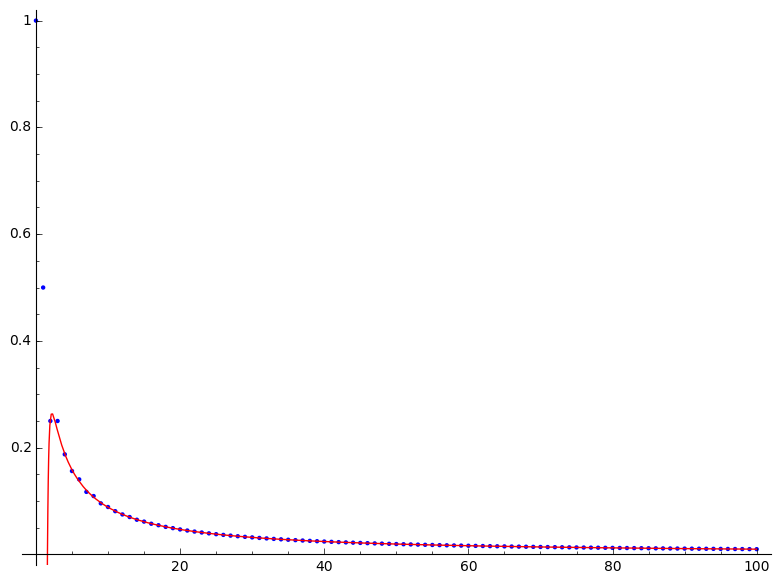

In [16]:
P = plot(asy_prob, n, 0.5, 100, ymin=0, color='red') + list_plot(prob); P

## Expected value $\mathbb{E} \tilde H_n$:

In [17]:
var('m n')

(m, n)

In [18]:
# this runs a long time
asy_exp_even = (4/(sqrt(pi)*sqrt(m) * (2*m - 1))
                * mellin_translation(truncate_inner(S(a,M,30), 30), 1, parity="even")).subs(m = (n + 2)/2) / asy_prob_even
asy_exp_odd = (4/(sqrt(pi)*sqrt(m) * (2*m - 1))
               * mellin_translation(truncate_inner(S(a,M,30), 30), 1, parity="odd")).subs(m = (n + 2)/2) / asy_prob_odd

In [19]:
asy_exp_even.taylor(n, oo, 7) - 2

1/4*sqrt(2)*pi^(3/2)*sqrt(n) + 3/16*sqrt(2)*pi^(3/2)/sqrt(n) - 539/5760*sqrt(2)*pi^(3/2)/n^(3/2) + 50713/483840*sqrt(2)*pi^(3/2)/n^(5/2) - 16671323/116121600*sqrt(2)*pi^(3/2)/n^(7/2) + 13114961/63078400*sqrt(2)*pi^(3/2)/n^(9/2) - 52266077173201/167382319104000*sqrt(2)*pi^(3/2)/n^(11/2) + 1001945317462289/2008587829248000*sqrt(2)*pi^(3/2)/n^(13/2) - 2

In [20]:
asy_exp_odd.taylor(n, oo, 7) - 2

1/4*sqrt(2)*pi^(3/2)*sqrt(n) + 3/16*sqrt(2)*pi^(3/2)/sqrt(n) - 539/5760*sqrt(2)*pi^(3/2)/n^(3/2) + 50713/483840*sqrt(2)*pi^(3/2)/n^(5/2) - 16671323/116121600*sqrt(2)*pi^(3/2)/n^(7/2) + 13114961/63078400*sqrt(2)*pi^(3/2)/n^(9/2) - 52266077173201/167382319104000*sqrt(2)*pi^(3/2)/n^(11/2) + 1001945317462289/2008587829248000*sqrt(2)*pi^(3/2)/n^(13/2) - 2

In [21]:
bool(asy_exp_even.taylor(n, oo, 7) - 2 == asy_exp_odd.taylor(n, oo, 7) - 2)

True

In [22]:
asy_exp = asy_exp_even.taylor(n, oo, 7) - 2; asy_exp

1/4*sqrt(2)*pi^(3/2)*sqrt(n) + 3/16*sqrt(2)*pi^(3/2)/sqrt(n) - 539/5760*sqrt(2)*pi^(3/2)/n^(3/2) + 50713/483840*sqrt(2)*pi^(3/2)/n^(5/2) - 16671323/116121600*sqrt(2)*pi^(3/2)/n^(7/2) + 13114961/63078400*sqrt(2)*pi^(3/2)/n^(9/2) - 52266077173201/167382319104000*sqrt(2)*pi^(3/2)/n^(11/2) + 1001945317462289/2008587829248000*sqrt(2)*pi^(3/2)/n^(13/2) - 2

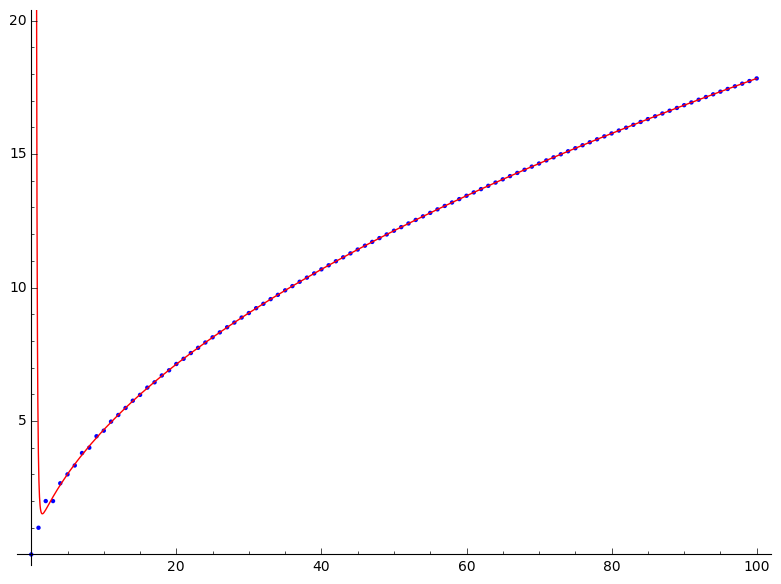

In [23]:
P = plot(asy_exp, n, 0.5, 100, color='red', ymax=20) + list_plot(prob_exp); P

## Variance $\mathbb{V} \tilde H_n$:

In [24]:
var('m n')

(m, n)

In [25]:
# this runs a long time
asy_var_even = (4/(sqrt(pi)*sqrt(m) * (2*m - 1)) 
                * mellin_translation(truncate_inner(S(a,M,30), 30), 2, parity="even")).subs(m = (n + 2)/2) / asy_prob_even \
                - asy_exp_even^2
asy_var_odd = (4/(sqrt(pi)*sqrt(m) * (2*m - 1)) 
               * mellin_translation(truncate_inner(S(a,M,30), 30), 2, parity="odd")).subs(m = (n + 2)/2) / asy_prob_odd \
                - asy_exp_odd^2

In [26]:
asy_var_even.taylor(n, oo, 5)

-3/16*pi^3 - 1/8*(pi^3 - 28*zeta(3))*n + 1/2880*(67*pi^3 - 1792*zeta(3))/n - 1/120960*(4189*pi^3 - 107520*zeta(3))/n^2 + 1/2073600*(98381*pi^3 - 2539520*zeta(3))/n^3 - 59/958003200*(990593*pi^3 - 27066368*zeta(3))/n^4 + 1/5230697472000*(421642510377*pi^3 - 12492906954752*zeta(3))/n^5 + 14/3*zeta(3)

In [27]:
asy_var_odd.taylor(n, oo, 5)

-3/16*pi^3 - 1/8*(pi^3 - 28*zeta(3))*n + 1/2880*(67*pi^3 - 1792*zeta(3))/n - 1/120960*(4189*pi^3 - 107520*zeta(3))/n^2 + 1/2073600*(98381*pi^3 - 2539520*zeta(3))/n^3 - 59/958003200*(990593*pi^3 - 27066368*zeta(3))/n^4 + 1/5230697472000*(421642510377*pi^3 - 12492906954752*zeta(3))/n^5 + 14/3*zeta(3)

In [28]:
bool(asy_var_odd.taylor(n, oo, 5) == asy_var_even.taylor(n, oo, 5))

True

In [29]:
asy_var = asy_var_even.taylor(n, oo, 5); asy_var

-3/16*pi^3 - 1/8*(pi^3 - 28*zeta(3))*n + 1/2880*(67*pi^3 - 1792*zeta(3))/n - 1/120960*(4189*pi^3 - 107520*zeta(3))/n^2 + 1/2073600*(98381*pi^3 - 2539520*zeta(3))/n^3 - 59/958003200*(990593*pi^3 - 27066368*zeta(3))/n^4 + 1/5230697472000*(421642510377*pi^3 - 12492906954752*zeta(3))/n^5 + 14/3*zeta(3)

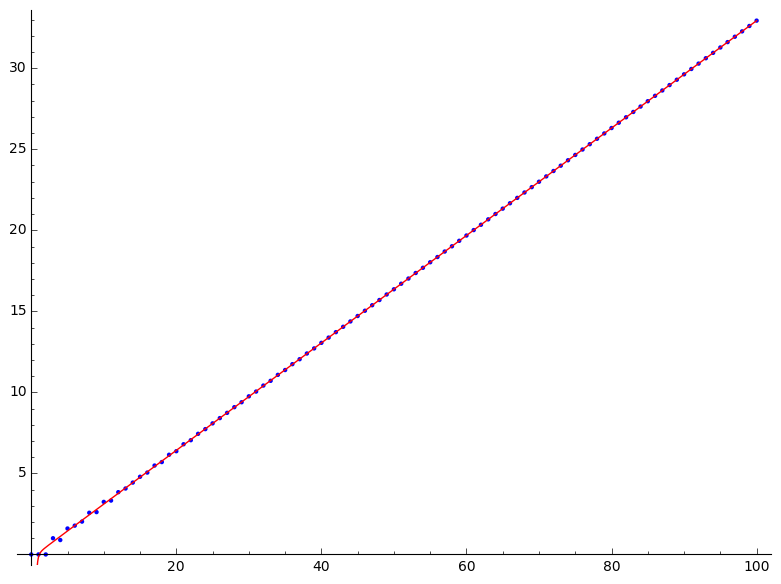

In [30]:
P = plot(asy_var, n, 0.5, 100, color='red', ymin=0) + list_plot(prob_var); P

## Corollary 4.1: Compute the asymptotic expansion for the number of ballot sequences by $B_n = q_{n-2} 2^{n-2}$

In [31]:
b_seq_asy = (asy_prob.subs(n=n-2)/4).taylor(n, oo, 8); b_seq_asy

1/4/n + 1/6/n^2 + 7/45/n^3 + 10/63/n^4 + 764/4725/n^5 + 4952/31185/n^6 + 2189392/14189175/n^7 + 983072/6081075/n^8

In [32]:
b_seq_prob = [q(n-2)/4 for n in range(101)]

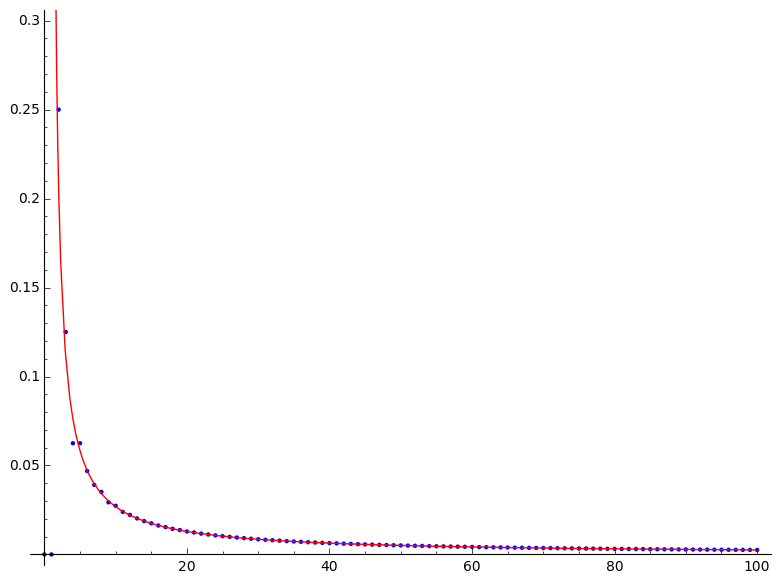

In [33]:
P = plot(b_seq_asy, n, 0.5, 100, ymax=0.3, color='red') + list_plot(b_seq_prob); P